In [5]:
import os
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
parent = os.path.join(Path(os.getcwd()).parent)

sys.path.append(parent)

from utils.results import SimulationResults

In [8]:
save_path = Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/msc-thesis/Figures/Python")

In [9]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

initialize runids

In [41]:
runids = [
    f'cal_gt{i}' for i in np.arange(1, 81+1, 1)
]

runids = [
    # 'val_gt21',
    # 'val_gt22',
    'val_gt23',
]

Load in calibration data

In [42]:
# load in Erikson data
df_erikson1 = pd.read_csv(
    os.path.join(parent, Path(r"database\raw_datasets\erikson2\Temp_arrays USGS-UCSC_Oberle\BI_T-1_processed.csv")), 
    parse_dates=['date_time'],
)

Define function to compute RMSE for each layer for each model run.

In [47]:
def compute_RMSE(run_id, df_val_data):
    
    # load in the modelling results
    fname_model_data = run_id + "_ground_temperature_timeseries.csv"

    df_gt = pd.read_csv(fname_model_data, parse_dates=['time'])

    # Lets add some columns to convert to Celcius
    erikson_colnames = df_val_data.columns[1:]
    
    colnames = [
        "temp_0.0m[K]","temp_0.25m[K]","temp_0.5m[K]","temp_0.75m[K]",
        "temp_1.0m[K]","temp_1.25m[K]","temp_1.5m[K]","temp_1.75m[K]",
        "temp_2.0m[K]","temp_2.25m[K]","temp_2.5m[K]","temp_2.75m[K]", "temp_2.95m[K]",
        "temp_3.0m[K]","temp_3.25m[K]","temp_3.5m[K]","temp_3.75m[K]",
        "temp_4.0m[K]","temp_4.25m[K]","temp_4.5m[K]","temp_4.75m[K]"
    ]
    
    for colname in colnames:
        
        df_gt[f'{colname[:-3]}[C]'] = df_gt[colname] - 273.15
     
    # remove repeated years from model data
    indice = np.max(df_gt[df_gt.time == df_gt.time.values[0]].index)
    df_gt = df_gt[df_gt.index >= indice]
        
    # make sure both dataframes span the same time frame
    t_start = np.max((df_gt.time.values[0], df_val_data.date_time.values[0]))
    # t_end = np.min((df_gt.time.values[-1], df_val_data.date_time.values[-1]))
    
    t_end = pd.to_datetime("2016-08-18")  # hard cutoff, since data temperature data obtained after this is incomplete

    mask1 = (df_gt['time'] >= t_start) * (df_gt['time'] <= t_end)    
    df1 = df_gt[mask1]

    mask2 = (df_val_data['date_time'] >= t_start) * (df_val_data['date_time'] <= t_end)    
    df2 = df_val_data[mask2]
    
    # print(df1.time)
    # print(df2.date_time)
    
    # compute RMSE per soil layer
    colnames1 = [
        "temp_0.0m[C]","temp_0.25m[C]","temp_0.5m[C]",
        "temp_1.0m[C]","temp_1.25m[C]","temp_1.5m[C]","temp_1.75m[C]",
        "temp_2.0m[C]","temp_2.25m[C]","temp_2.5m[C]","temp_2.75m[C]",
        "temp_3.0m[C]","temp_3.25m[C]","temp_3.5m[C]","temp_3.75m[C]",
        "temp_4.0m[C]","temp_4.25m[C]",
    ]
    colnames2 = [
        'dpth0cm', 'dpth25cm', 'dpth50cm', 
        'dpth100cm', 'dpth125cm', 'dpth150cm', 'dpth175cm', 
        'dpth200cm', 'dpth225cm', 'dpth250cm', 'dpth275cm', 
        'dpth300cm', 'dpth325cm', 'dpth350cm', 'dpth375cm',
        'dpth400cm', 'dpth425cm'
    ]
    
    RMSEs = {'runid':run_id}
    
    
    for c1, c2 in zip(colnames1, colnames2):
        
        values1 = df1[c1].values
        values2 = df2[c2].values
        
        N = len(values1)
        
        RMSE = np.sqrt(1 / N * np.sum((values1 - values2)**2))
        
        RMSEs[c2] = RMSE
        
    return RMSEs
    

In [48]:
i = 0

for run_id in runids:

    RMSEs = compute_RMSE(run_id, df_erikson1)
        
    if i == 0:
        
        df_rmse = pd.DataFrame(RMSEs, index=[0])

    else:
        
        df_rmse = df_rmse._append(RMSEs, ignore_index=True)
        
display(df_rmse)

,runid,dpth0cm,dpth25cm,dpth50cm,dpth100cm,dpth125cm,dpth150cm,dpth175cm,dpth200cm,dpth225cm,dpth250cm,dpth275cm,dpth300cm,dpth325cm,dpth350cm,dpth375cm,dpth400cm,dpth425cm
0,val_gt23,8.909067,4.635957,1.415411,0.147197,0.161563,0.427838,0.680628,1.02819,1.392608,1.6235,1.5788,0.751595,0.240227,0.545376,0.874849,0.957247,1.047905


In [50]:
len(df_rmse.columns[1:])

17

C:\Users\bruij_kn\AppData\Local\Temp\ipykernel_31604\3461091560.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


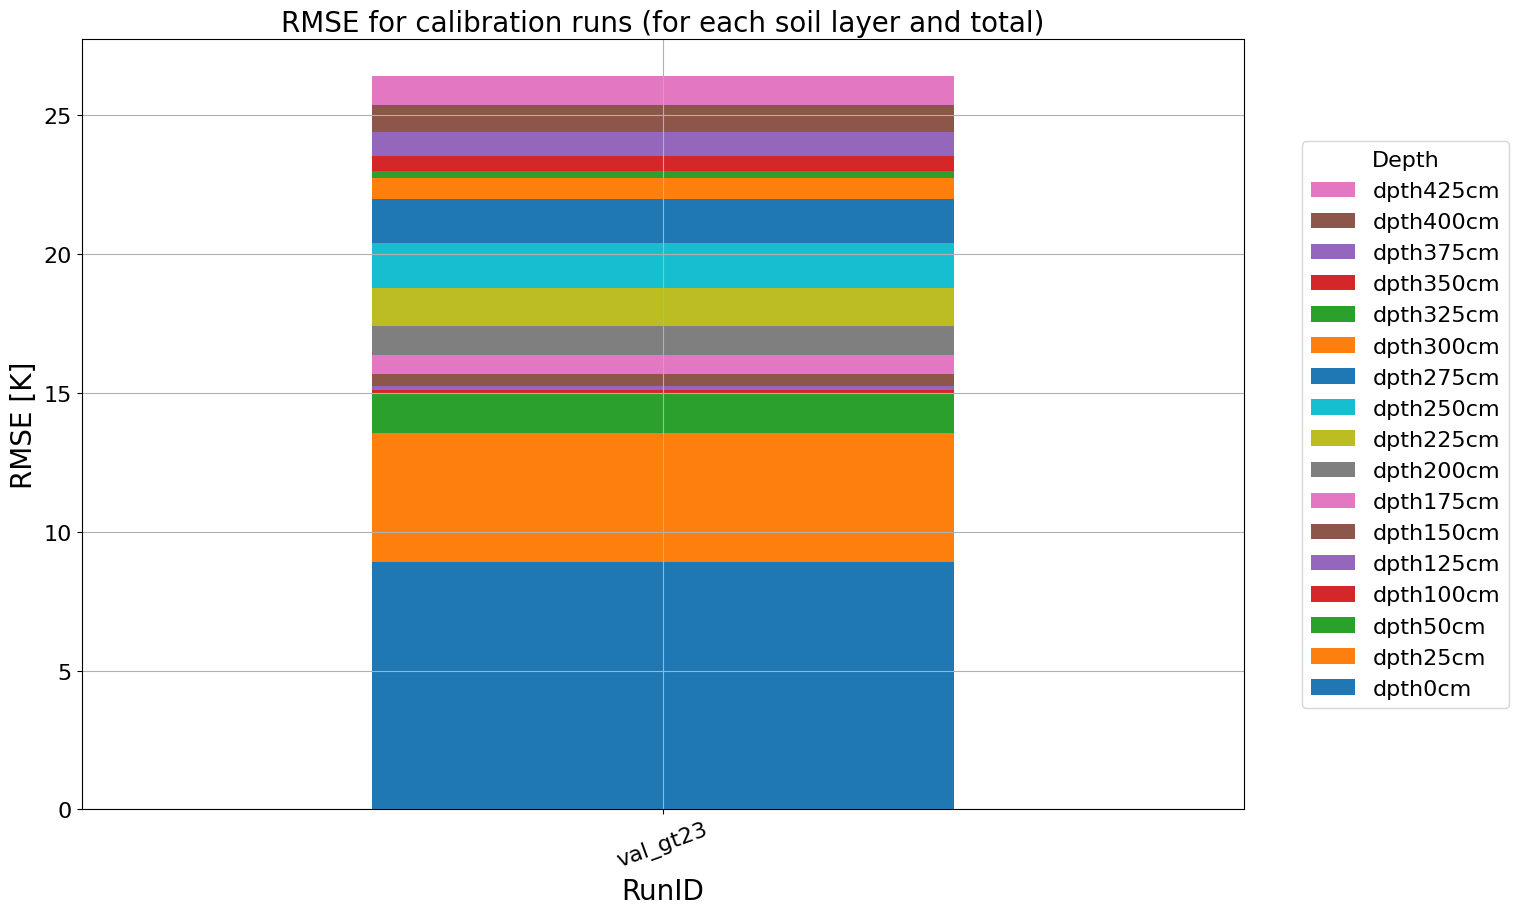

In [57]:
fig, ax = plt.subplots(figsize=(15, 10))

df_rmse.plot.bar(stacked=True, ax=ax)

ax.set_title("RMSE for calibration runs (for each soil layer and total)")
ax.set_xlabel('RunID')
ax.set_ylabel('RMSE [K]')

ax.set_xticks(np.arange(len(df_rmse)), df_rmse.runid.values)
ax.set_xticklabels(df_rmse.runid.values, rotation=20)

ax.grid()

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Depth', bbox_to_anchor=(1.04, 0.5), loc="center left")



fig.show()